## Outline

### Part 1: Run simulation and calculate group shift

1. Create scenario where agents are fully connected with a specified  opinion mean and variance. 
1. Internally, initial opinions will be genrated using that mean and variance.
1. Run a simulation for a given number of steps that will be specified by the individual empirical setting we want to model.
1. Calculate final mean; subtract initial mean from final mean to get the group polarization shift.

### Part 2: Modfiy polarization.py code to set $\alpha$

### Part 3: Fit model to empirical data

1. Run experiment many times until $\alpha$ found that causes shifts to match.


## Part 1

In [3]:
import numpy as np

import sys
sys.path.append('../polarization/polarization/')

from polarization import Experiment, Network, Agent
import networkx as nx
graph = nx.complete_graph(4)

# agents = [Agent(n_opinions=1) for _ in range(4)]
graph = nx.relabel_nodes(
    graph, 
    {n: Agent(n_opinions=1, low_opinion=0.25, high_opinion=0.75) for n in graph.nodes()}
)

n = Network(graph)

mean_ops = lambda net: np.mean([nd.opinions[0] for nd in n.graph.nodes()])

init_mean = mean_ops(n)
for it in range(10):
    n.iterate()
    print([nd.opinions[0] for nd in n.graph.nodes()])
final_mean = mean_ops(n)
shift = final_mean - init_mean
print("\nInitial mean: {}\nFinal mean: {}\nDifference: {}".format(init_mean, final_mean, shift))

[0.6110070277370631, 0.478584770269384, 0.5543573772107447, 0.5217622247989323]
[0.6110070277370631, 0.478584770269384, 0.5481886277700047, 0.5217622247989323]
[0.6110070277370631, 0.4969809200389373, 0.5481886277700047, 0.5269985342366547]
[0.6110070277370631, 0.4969809200389373, 0.5481886277700047, 0.5269985342366547]
[0.6110070277370631, 0.5119647006400875, 0.5481886277700047, 0.533550360252695]
[0.5856199569977515, 0.5119647006400875, 0.5481886277700047, 0.5414682896185109]
[0.5856199569977515, 0.5226831792386166, 0.5481886277700047, 0.5414682896185109]
[0.5856199569977515, 0.5226831792386166, 0.5481886277700047, 0.5436825521649757]
[0.5856199569977515, 0.5226831792386166, 0.5488297937316453, 0.546982956929135]
[0.5856199569977515, 0.5226831792386166, 0.5494384832759641, 0.546982956929135]

Initial mean: 0.5231590573241524
Final mean: 0.5511811441103668
Difference: 0.02802208678621443


In [4]:
class ShiftExperiment:
    
    def __init__(self, n_agents, low_init_op, high_init_op):
        ## Initialize the interaction Network. 
        
        # Begin with a complete graph and assigning graph nodes to be Agents
        # with specified initial opinions.
        graph = nx.complete_graph(n_agents)
        graph = nx.relabel_nodes(
            graph, 
            {n: Agent(n_opinions=1, low_opinion=low_init_op, high_opinion=high_init_op) 
             for n in graph.nodes()}
        )
        # Only considering one-dimensional opinion vectors for now.
        self.init_opinions = [nd.opinions[0] for nd in graph.nodes()]
        self.network = Network(graph)        
    
    def run(self, n_iter, alpha=1):
        '''
        Iterate the system the specified number of times to run the experiment.
        
        Returns:
            (ShiftExperimentResult): Object that holds the initial and
                final opinions and the network.
        '''
        for _ in range(n_iter):
            self.network.iterate(alpha=alpha)
        
        self.final_opinions = [nd.opinions[0] for nd 
                               in self.network.graph.nodes()]
        
        return ShiftExperimentResult(
            self.init_opinions, self.final_opinions, self.network
        )
    
    
class ShiftExperimentResult:
    
    def __init__(self, initial_opinions, final_opinions, network):
        self.initial_opinions = initial_opinions
        self.final_opinions = final_opinions
        self.network = network
        self.shift = np.mean(final_opinions) - np.mean(initial_opinions)

(array([1., 0., 0., 1., 1., 0., 0., 6., 2., 2., 6., 3., 8., 4., 9., 8., 8.,
        7., 9., 4., 4., 8., 2., 4., 0., 2., 0., 0., 0., 1.]),
 array([0.0042563 , 0.0051358 , 0.0060153 , 0.0068948 , 0.0077743 ,
        0.0086538 , 0.0095333 , 0.0104128 , 0.01129231, 0.01217181,
        0.01305131, 0.01393081, 0.01481031, 0.01568981, 0.01656931,
        0.01744881, 0.01832832, 0.01920782, 0.02008732, 0.02096682,
        0.02184632, 0.02272582, 0.02360532, 0.02448482, 0.02536433,
        0.02624383, 0.02712333, 0.02800283, 0.02888233, 0.02976183,
        0.03064133]),
 <a list of 30 Patch objects>)

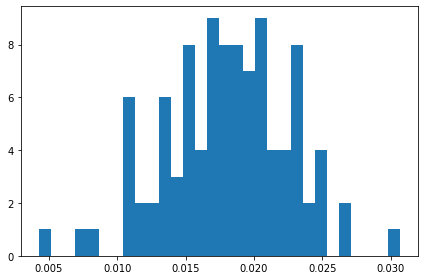

In [5]:
# %%timeit -n1 -r1
# %%timeit

n_trials = 100
shifts = np.zeros((n_trials,), dtype=float)
for idx in range(n_trials):
    experiment = ShiftExperiment(25, 0.55, 0.95)
    res = experiment.run(10)
    shifts[idx] = res.shift
#     print(res.shift)


import matplotlib.pyplot as plt

plt.hist(shifts, bins=30)

In [6]:
print(np.mean(shifts))
print(np.std(shifts))
print(np.mean(shifts)*9)
print(np.std(shifts)*9)

0.01806106739134572
0.004559954717981315
0.16254960652211148
0.041039592461831836


In [7]:
print("Myers & Bishop 1970 Low prej.:\nInit: ", 
      2.94 / 9, "\nFinal:", 3.41 / 9)
print("Myers & Bishop 1970 Med. prej.:\nInit: ", 
      1.3 / 9, "\nFinal:", 0.67 / 9, "\n")
print("Myers & Bishop 1970 High prej.:\nInit: ", 
      -1.7 / 9, "\nFinal:", -3.01 / 9, "\n")

print("Myers 1975 Chauvinists:\nInit: ", 
      -1.11 / 7, "\nFinal:", -1.14 / 7, "\n")
print("Myers 1975 Feminists:\nInit: ", 
      0.78 / 7, "\nFinal:", 1.72 / 7, "\n")

Myers & Bishop 1970 Low prej.:
Init:  0.32666666666666666 
Final: 0.3788888888888889
Myers & Bishop 1970 Med. prej.:
Init:  0.14444444444444446 
Final: 0.07444444444444445 

Myers & Bishop 1970 High prej.:
Init:  -0.18888888888888888 
Final: -0.33444444444444443 

Myers 1975 Chauvinists:
Init:  -0.15857142857142859 
Final: -0.16285714285714284 

Myers 1975 Feminists:
Init:  0.11142857142857143 
Final: 0.24571428571428572 



## Part 2: Modify existing code to be able to set $\alpha$

The existing code I'm using is in `polarization/polarization/polarization.py`. Soon I need to take some time to create a new file with project-specific code and burn the unneeded chaff from the paths to polarization project. But not yet, I'll do it once I have a solid prototype study with the five bits of data I listed above and included in the two-page abstract.

Done with mod, was an easy change. `Network.iterate` (l. 173) calls `opinion_update_vec` (l. 372) which implements that part of the equation. I added a kwarg `alpha` to both of those, and if it is provided the absolute value of the opinion raised to the power of $\alpha$ is used instead of just the opinion itself. 

In [8]:
n_trials = 100

def run_trials(n_agents, alpha, init_op_min, init_op_max, n_iter=10, n_trials=100):
    
    shifts = np.zeros((n_trials,), dtype=float)

    for idx in range(n_trials):
        experiment = ShiftExperiment(n_agents, init_op_min, init_op_max)
        res = experiment.run(n_iter, alpha)
        shifts[idx] = res.shift
    
    return shifts

In [9]:
n_agents = 25
alpha = 1.0
init_op_min = .65
init_op_max = .75
n_iter = 10
n_trials = 100

# shifts = run_trials(n_agents, alpha, init_op_min, init_op_max, n_iter, n_trials)

(array([ 1.,  2.,  8., 11., 21., 23., 17., 14.,  2.,  1.]),
 array([0.0042563 , 0.0068948 , 0.0095333 , 0.01217181, 0.01481031,
        0.01744881, 0.02008732, 0.02272582, 0.02536433, 0.02800283,
        0.03064133]),
 <a list of 10 Patch objects>)

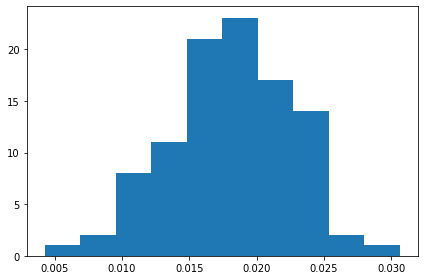

In [10]:
plt.hist(shifts)

In [11]:
# Check to see if setting alpha differently significantly affects results.

alphas = [0.85, 1.0, 3]
means_over_alphas = np.zeros(len(alphas))

for idx, alpha in enumerate(alphas):
    print()
    means_over_alphas[idx] = np.mean(
        run_trials(n_agents, alpha, init_op_min, init_op_max, n_iter, n_trials)
    )

print(means_over_alphas)




[0.00091814 0.00082716 0.00079504]


In [12]:
n_iter = 8
n_trials = 50

alphas = [0.05, 0.7, 0.9, 0.95, 1.0, 1.1] #, 5]
means_over_alphas = np.zeros(len(alphas))

init_op_min = .2
init_op_max = .8

for idx, alpha in enumerate(alphas):

    means_over_alphas[idx] = np.mean(
        run_trials(n_agents, alpha, init_op_min, init_op_max, n_iter, n_trials)
    )

print(means_over_alphas)

[0.00357473 0.02277619 0.02433154 0.02178393 0.02599649 0.0243217 ]


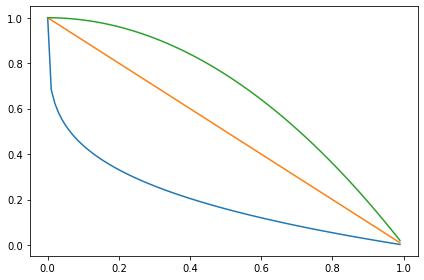

In [13]:
x = np.arange(0, 1, .01)
y1 = 1 - np.power(x, .25)
y2 = 1 - x
y3 = 1 - np.power(x, 2)
plt.plot(x, y1)
plt.plot(x, y2)
plt.plot(x, y3)

### Results of initial tries

It appears this approach will not work. Interestingly it seems the linear term where $\alpha=1$ results in the maximum shift. Still, it also appears to be tunable, so maybe it's possible to use somehow. To start I will see what the shifts are in the linear case for the five studies whose data I have above. 

In [14]:
class ObservedShift:
    
    def __init__(self, study_id, condition_id, initial_mean, 
                 final_mean, opinion_scale):
        
        self.study_id = study_id
        self.condition_id = condition_id
        self.initial_mean = initial_mean
        self.final_mean = final_mean
        self.opinion_scale = 9
        
        self.shift = self.final_mean - self.initial_mean
        # The maximum extremity is +/- opinion_scale.
        # Later bins will be made for, e.g. 4.5 to 3.5 will
        # be a 4, -0.5 to 0.5 will be 0 and so on.
        self.extremity_factor = opinion_scale / 2.0 

# See p. 779 of Myers & Bishop 1970 in Science
study_id = 'Myers & Bishop 1970'
opinion_scale = 9

condition_id = 'Low Prejudice'
studies = [
    ObservedShift(study_id, condition_id, 2.94, 3.41, opinion_scale)
]

condition_id = 'Medium Prejudice'
studies.append(
    ObservedShift(study_id, condition_id, 1.30, 0.67, opinion_scale)
)

condition_id = 'High Prejudice'
studies.append(
    ObservedShift(study_id, condition_id, -1.70, -3.01, opinion_scale)
)

# See p. 710 in Myers 1975 in Human Relations 
study_id = 'Myers 1975'
opinion_scale = 7

condition_id = 'Feminists'
studies.append(
    ObservedShift(study_id, condition_id, 0.78, 1.72, opinion_scale)
)

condition_id = 'Chauvinists'
studies.append(
    ObservedShift(study_id, condition_id, -1.11, -1.14, opinion_scale)
)

In [15]:
for study in studies:
    print("Study: {}, Condition: {}".format(
        study.study_id, study.condition_id)
    )
    print("Shift scaled to +/- 1: {}\n".format(
        study.shift / study.extremity_factor)
    )

Study: Myers & Bishop 1970, Condition: Low Prejudice
Shift scaled to +/- 1: 0.10444444444444449

Study: Myers & Bishop 1970, Condition: Medium Prejudice
Shift scaled to +/- 1: -0.14

Study: Myers & Bishop 1970, Condition: High Prejudice
Shift scaled to +/- 1: -0.2911111111111111

Study: Myers 1975, Condition: Feminists
Shift scaled to +/- 1: 0.26857142857142857

Study: Myers 1975, Condition: Chauvinists
Shift scaled to +/- 1: -0.008571428571428516



OK, so currently my approach is not generating these numbers, but there is a step I have forgotten: pre- and post-binning of continuous opinions into discrete opinions. The scheme I want to use for this is to make $\pm 1.0$ be $\pm EF / 2.0 -/+ 0.01$ (EF stands for extremity factor). For example, if the study has used a seven-point scale then $\pm 1.0$ would correspond to $\pm 3.5$.

Generating the pre- and post-discussion opinions we do the following. First, generate random initial opinions using a normal distribution with mean equal to the observed mean and a standard deviation of $PS / 4$ since we don't know the standard deviation for the studies I'm using as an example. Then I will bin each opinion with the following scheme. If, for example, the scale is nine-point then the categories are -4, -3, ..., 3, 4. I will clip opinions at $\pm 4.4$ in this case as generated by the normal distribution. Then I will bin each continuous opinion by doing simple rounding. Thus, if an opinion is -1.2 it will be binned to -1. If it is -1.7 it will be binned to -2.

In [16]:
# from util import initial_opinions, cont_to_cat, cat_to_cont

# # Demonstrate the use of these three as specified above.
# ops = initial_opinions(n=4, mean=3.2, scale=9)


In [17]:
from numpy.random import normal

samples = normal(1.0, 2.0, size=5)
samples

rounded = np.array([round(x) for x in samples])
# print(np.mean(rounded))
# print(np.mean(samples))

def cont_to_cat(vals, extremity_factor):
#     print(type(vals))
    vals = vals * extremity_factor
#     print(vals)
    vals[vals > extremity_factor] = extremity_factor
    vals[vals < -extremity_factor] = - extremity_factor
    rounded = np.array([round(x) for x in vals])
    return rounded

# Quick experiment to see average diff between original and rounded means
# size = 20
# n_trials = 10000
# minmax = 4.49
# sd = minmax / 2
# mean = -1.7
# res = np.zeros((n_trials,), dtype=float)
# for idx in range(n_trials):
#     samples = normal(mean, sd, size=size)
#     rounded = cont_to_cat(samples, minmax)
# #     print(rounded)
#     res[idx] = samples.mean() - rounded.mean()
    
# print(res.mean())
# plt.hist(res, bins=30)
# print(res.max())
# print(res.min())


### Final outline of process

1. Generate initial opinions with given mean. (Set a threshold to only use continuous distributions that closely match the corresponding binned distributions? No, seems wrong to assume initial continuous opinions should be any more faithful to categorical distribution than final opinions.)
1. Run dynamics with continuous initial opinions.
1. After n_iter interactions, stop simulation, bin opinions, and measure the mean.

Use above code as a guide with the continuous-to-categorical mapping function where necessary.

In [18]:
class ShiftExperiment:
    
    def __init__(self, n_agents, initial_dist, 
                 extremity_factor=4.49, **initial_dist_kwargs):
        '''
        Arguments:
            n_agents (int): Number of agents for each simulation trial
            initial_dist (numpy.random function): e.g. numpy.random.normal
            dist_kwargs (dict): additional parameters needed for defining
             given initial_dist distribution function, e.g. loc=0.0,
             scale=1.0, size=(n_agents,) for n_agents samples from normal
             distribution with mean 0 and sd 1.
        '''
        ## Initialize the interaction Network. 
        
        # Begin with a complete graph and assigning graph nodes to be Agents
        # with specified initial opinions.
        graph = nx.complete_graph(n_agents)
        
        # Make nodes into agents with one opinion. Under the hood this
        # still initializes opinions to be uniform random, but these
        # will be overwritten using user-provided distribution.
        graph = nx.relabel_nodes(
            graph, 
            {n: Agent(n_opinions=1)  # , low_opinion=low_init_op, high_opinion=high_init_op) 
             for n in graph.nodes()}
        )
        
        # Initialize each agent's opinions based on 
        # provided distribution.
        for node in graph.nodes():
            val = initial_dist(**initial_dist_kwargs)
#             print(val)
            if val > extremity_factor:
                node.opinions[0] = 1.0
            elif val < -extremity_factor:
                node.opinions[0] = -1.0
            else:
                node.opinions[0] = val / extremity_factor
                
        # Extract each agent's opinion.
        self.init_opinions = [nd.opinions[0] for nd in graph.nodes()]
        
        # Initialize Network that will be iterated.
        self.network = Network(graph)
        
        # Store extremity_factor to pass on to ShiftExperimentResult
        # to convert continuous variables to categorical variables.
        self.extremity_factor = extremity_factor
    
    def run(self, n_iter, alpha=1):
        '''
        Iterate the system the specified number of times to run the experiment.
        
        Returns:
            (ShiftExperimentResult): Object that holds the initial and
                final opinions and the network.
        '''
        # Iterate the system a given number of times, approximating the
        # number of rounds of interaction in an experiment.
        for _ in range(n_iter):
            self.network.iterate(alpha=alpha)
        
        # Extract the opinions of each agent at the final timestep.
        self.final_opinions = [nd.opinions[0] for nd 
                               in self.network.graph.nodes()]
        
        # Wrap results and other info into ShiftExperimentResult.
        return ShiftExperimentResult(
            self.init_opinions, self.final_opinions, self.network,
            self.extremity_factor
        )
    
    
class ShiftExperimentResult:
    
    def __init__(self, initial_opinions, final_opinions, 
                 network, extremity_factor):
        
        
        self.initial_opinions = np.array(initial_opinions)
        self.final_opinions = np.array(final_opinions)
        
        self.network = network
        final_cat = cont_to_cat(self.final_opinions, extremity_factor)
        initial_cat = cont_to_cat(self.initial_opinions, extremity_factor)

#         print(initial_cat)
#         print(final_cat)

        self.shift = np.mean(final_cat) - np.mean(initial_cat)
        

    
def run_trials(n_agents, alpha, extremity_factor, initial_dist=np.random.normal, 
               n_iter=10, n_trials=100, **initial_dist_kwargs):
    
    shifts = np.zeros((n_trials,), dtype=float)

    for idx in range(n_trials):
        experiment = ShiftExperiment(
            n_agents, initial_dist, 
            extremity_factor=extremity_factor, **initial_dist_kwargs)
        res = experiment.run(n_iter, alpha)
        shifts[idx] = res.shift
    
#     print(res.initial_opinions)
#     print(res.final_opinions)
    
    return shifts


In [21]:
# Initialize feminist group from Myers 1975.
n_agents = 26
n_trials = 10
n_iter = 500
alpha = 1.0
init_mean = 0.78
extremity_factor = 3.49  # 7-point scale
init_stddev = extremity_factor / 3.0  # Arbitrary assumption.


shifts = run_trials(n_agents, alpha, extremity_factor, n_iter=n_iter, 
                    n_trials=n_trials, loc=init_mean, 
                    scale=init_stddev)

# exp = ShiftExperiment(n_agents=5, initial_dist=np.random.normal, 
#                       extremity_factor=extremity_factor, 
#                       loc=0.78, scale=extremity_factor / 2.0)

print(shifts.min())
print(shifts.max())
print(shifts.mean())
print(shifts.stddev())
plt.hist(shifts)

-0.46153846153846156
1.9230769230769231
0.5961538461538461


AttributeError: 'numpy.ndarray' object has no attribute 'stddev'

In [22]:
shifts.std()

0.6728571069629364